In [1]:
import numpy as np
import os
from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras_preprocessing.image import load_img
from keras_preprocessing import image
from keras_preprocessing.image import img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
import math
import random

In [2]:
def preprocess(array):
    array = array.astype("float32")/255
    return array

In [3]:
def noise_speckle(image, seed=None, clip=True):
    # Detect if a signed image was input
    if image.min() < 0:
        low_clip = -1.0
    else:
        low_clip = 0.0

    image = preprocess(image)
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, 0.1 ** 0.5, image.shape)
    out = image + image * noise

    # Clip back to original range, if necessary
    if clip:
        out = np.clip(out, low_clip, 1.0)

    out = out * 255
    out = out.astype("uint8")
    return out

In [4]:
path="D:/raw-img"

In [5]:
import os
image_list=[]
n=0
for path, subdirs, files in os.walk(path):
    for name in files:  
        filename=path+'/'+name
        filename=filename.replace('\\','/')
        image_list.append(filename)
        n=n+1     

In [6]:
X = []
y = []
for i in tqdm(range(0,n)):
    filename = image_list[i]
    Images = imread(filename)
    Images = resize(Images, (150,150,3))
    Images = Images * 255
    Images = Images.astype("uint8")
    Images = noise_speckle(Images)
    imsave((filename+'__'+'speckle'+'_noise_.JPEG'), Images)
    # extracting class name from filename
    class_name = filename.split('/')[-2]
    # appending image and label to X and y lists
    X.append(Images)
    y.append(class_name)
    
# converting X and y to numpy arrays
X = np.array(X)
y = np.array(y)


 36%|███████████████████████████▌                                                 | 9354/26179 [02:33<10:58, 25.56it/s]C:\Users\smart pc\AppData\Local\Temp\ipykernel_12024\2415502073.py:10: UserWarning: D:/Folder dwipa/raw-img noise/farfalla/eb35b30729f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png__speckle_noise_.JPEG is a low contrast image
  imsave((filename+'__'+'speckle'+'_noise_.JPEG'), Images)
100%|████████████████████████████████████████████████████████████████████████████| 26179/26179 [11:05<00:00, 39.31it/s]


In [7]:
le = preprocessing.LabelEncoder()
le.fit(y)
y_encode = le.transform(y)

In [8]:
y_one_hot = tf.keras.utils.to_categorical(y_encode, num_classes=10)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.04, random_state=42)

In [10]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X


In [11]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [12]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [13]:
base_model = ResNet50(input_shape=(150,150, 3))

In [14]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [15]:
model = Model(inputs=base_model.input, outputs=headModel)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 75, 75, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1[0][0]']              

 res2c_branch2c (Conv2D)        (None, 37, 37, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 37, 37, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 37, 37, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 37, 37, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 res3a_bra

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 19, 19, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 19, 19, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 19, 19, 128)  512        ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_19 (Activation)     (None, 19, 19, 128)  0           ['bn3d_branch2a[0][0]']          
          

 activation_27 (Activation)     (None, 10, 10, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 res4c_branch2a (Conv2D)        (None, 10, 10, 256)  262400      ['activation_27[0][0]']          
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, 10, 10, 256)  1024       ['res4c_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_28 (Activation)     (None, 10, 10, 256)  0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_bra

 bn4f_branch2a (BatchNormalizat  (None, 10, 10, 256)  1024       ['res4f_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_37 (Activation)     (None, 10, 10, 256)  0           ['bn4f_branch2a[0][0]']          
                                                                                                  
 res4f_branch2b (Conv2D)        (None, 10, 10, 256)  590080      ['activation_37[0][0]']          
                                                                                                  
 bn4f_branch2b (BatchNormalizat  (None, 10, 10, 256)  1024       ['res4f_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activatio

                                                                                                  
 res5c_branch2b (Conv2D)        (None, 5, 5, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 bn5c_branch2b (BatchNormalizat  (None, 5, 5, 512)   2048        ['res5c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_47 (Activation)     (None, 5, 5, 512)    0           ['bn5c_branch2b[0][0]']          
                                                                                                  
 res5c_branch2c (Conv2D)        (None, 5, 5, 2048)   1050624     ['activation_47[0][0]']          
                                                                                                  
 bn5c_bran

In [17]:
base_model.load_weights("resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000013B0FD77790> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000013B6B391F40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000013B6B388400> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000013B6B3884C0> False
<keras.layers.core.activation.Activation object at 0x0000013B0FE1D790> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000013B687796D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000013B633CAF40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000013B0FD74970> False
<keras.layers.core.activation.Activation object at 0x0000013B686FA790> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000013B379D6F40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000013B633CA850> False
<keras.layers.core.activation.Activation object at 0x000

In [20]:
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

In [21]:
history=model.fit(
    X_train,y_train,
    epochs=100,
    batch_size=100,
    validation_data=(X_test,y_test)
    )

Epoch 1/100
252/252 [==============================] - 341s 1s/step - loss: 1.0966 - accuracy: 0.6880 - val_loss: 0.7970 - val_accuracy: 0.7300
Epoch 2/100
252/252 [==============================] - 354s 1s/step - loss: 0.5148 - accuracy: 0.8263 - val_loss: 0.7282 - val_accuracy: 0.7691
Epoch 3/100
252/252 [==============================] - 339s 1s/step - loss: 0.3684 - accuracy: 0.8753 - val_loss: 0.7429 - val_accuracy: 0.7672
Epoch 4/100
252/252 [==============================] - 343s 1s/step - loss: 0.2341 - accuracy: 0.9194 - val_loss: 0.7593 - val_accuracy: 0.7834
Epoch 5/100
252/252 [==============================] - 360s 1s/step - loss: 0.1540 - accuracy: 0.9494 - val_loss: 0.8781 - val_accuracy: 0.7786
Epoch 6/100
252/252 [==============================] - 377s 1s/step - loss: 0.1183 - accuracy: 0.9598 - val_loss: 1.0127 - val_accuracy: 0.7786
Epoch 7/100
252/252 [==============================] - 369s 1s/step - loss: 0.0981 - accuracy: 0.9673 - val_loss: 1.0396 - val_accuracy:

In [22]:
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test)
y_pred_one_hot=np.argmax(y_pred,axis=1)
y_test_one_hot=np.argmax(y_test,axis=1)
confusion_mat=confusion_matrix(y_test_one_hot, y_pred_one_hot)
print(confusion_mat)

33/33 [==============================] - 16s 456ms/step
[[143   6   4   0   4  11   4   5   6   4]
 [ 11  94   4   0   4   3   3   1   2   3]
 [  1   1  58   0   2   0   2   0   1   1]
 [  1   0   0  62   5   2   0   0  13   0]
 [  6   0   0   2  91   1   0   2   8   2]
 [ 11   0   0   0   1  52   1   0   2   4]
 [  2   8   3   0   1   0  37   6   1   0]
 [  6   2   9   0   3   4   5  46   1   0]
 [  1   0   0   4   3   0   1   0 178   0]
 [  7   1   1   0   5   7   0   0   7  55]]


In [23]:
report= classification_report(y_test_one_hot,y_pred_one_hot)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       187
           1       0.84      0.75      0.79       125
           2       0.73      0.88      0.80        66
           3       0.91      0.75      0.82        83
           4       0.76      0.81      0.79       112
           5       0.65      0.73      0.69        71
           6       0.70      0.64      0.67        58
           7       0.77      0.61      0.68        76
           8       0.81      0.95      0.88       187
           9       0.80      0.66      0.72        83

    accuracy                           0.78      1048
   macro avg       0.77      0.75      0.76      1048
weighted avg       0.78      0.78      0.78      1048



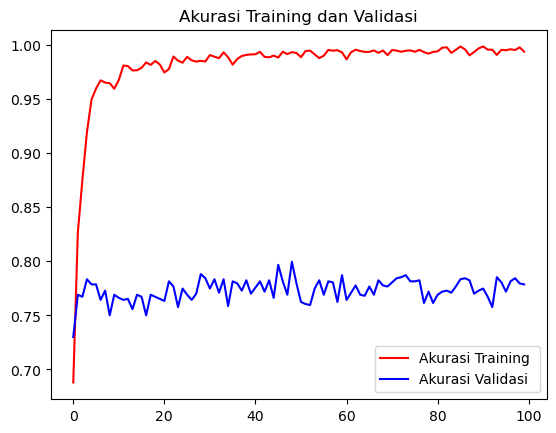

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt                                                   #Mengimpor modul matplotlib
acc = history.history['accuracy']                                                 #Nilai akurasi training
val_acc = history.history['val_accuracy']                                         #Nilai akurasi validasi
loss = history.history['loss']                                                    #Nilai loss training
val_loss = history.history['val_loss']                                            #Nilai loss validasi

epochs = range(len(acc))                                                          #Jumlah epoch

plt.plot(epochs, acc, 'r', label='Akurasi Training ')                             #Plot nilai akurasi training                     
plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')                          #Plot nilai akurasi validasi
plt.title('Akurasi Training dan Validasi')                                        #Menamai gambar
plt.legend(loc=0)                                                                 #Menampilkan legenda
plt.figure()                                                                      
plt.show()